In [227]:
using LinearAlgebra
using Distributions
using Plots
using Statistics

In [228]:
"""
A `Point` is a pair of coordinates (x,y).
"""
struct Point{T<:Real}
    x::T
    y::T
end

# Basic operations on pairs of points: Compute the length between them and their midpoint.
Base.length(p::Point, q::Point) = sqrt((p.x-q.x)^2 + (p.y-q.y)^2)
mean_point(p::Point, q::Point) = Point((p.x+q.x)/2, (p.y+q.y)/2);

In [229]:
abstract type AbstractGrid end

"""
A `Grid` is a regular 2D grid defined by an array of `nodes`, along with the spacing between the nodes
determined by `Δx` and `Δy`. The nodes define the lower-left corners of the cells of the `Grid`.
Associated to the `nodes` are `centers`, which are the coordinates of the cell centers for each grid point.
For convencience, `xticks` and `yticks` store the x- and y- coordinates in separate arrays, like ticks 
on a plot. In addition, `nx` and `ny` is the number of cells along the x- and y-dimension.
"""
mutable struct Grid{T<:AbstractFloat} <: AbstractGrid
    nodes::Array{Point{T},1}
    centers::Array{Point{T},1}
    Δx::T
    Δy::T
    xticks::Array{T}
    yticks::Array{T}
    nx::Int64
    ny::Int64
end


function Grid(nx::Int64, ny::Int64, Δx::Float64, Δy::Float64)
    xticks = collect(0:Δx:nx*Δx)
    yticks = collect(0:Δy:ny*Δy)
    nodes = Point{Float64}[]
    centers = Point{Float64}[]
    for row in 1:nx
        for col in 1:ny
            x = xticks[row]; y = yticks[col]
            push!(nodes, Point(x, y))
            push!(centers, Point(x + Δx/2, y + Δy/2))
        end
    end
    return Grid(nodes, centers, Δx, Δy, xticks, yticks, nx, ny)
end

"""
Compute the grid bounding box. 
Returns the minimum and maximum x- and y-coordinates of the grid.
"""
function bounding_box(grid::Grid)
    xmin = minimum(grid.xticks); xmax = maximum(grid.xticks)
    ymin = minimum(grid.yticks); ymax = maximum(grid.yticks)
    return [xmin, ymin, xmax, ymax]
end

""""
Returns a matrix where a non-zero value implies that the row (cell) and column (other cell) are neighbors.
"""
function grid_neighbors(grid::Grid)
    c = grid.centers; nc = length(c)
    neighbors = zeros(Int64, nc, nc)
    for (idx, cell) in enumerate(c)
        for odx in idx+1:nc  # Only compare points that haven't been compared before
            ocell = c[odx];
            xngb = (abs(cell.x - ocell.x) ≈ grid.Δx) & (cell.y ≈ ocell.y)
            yngb = (abs(cell.y - ocell.y) ≈ grid.Δy) & (cell.x ≈ ocell.x)
            if xngb | yngb
                neighbors[idx, odx] = neighbors[odx, idx] = 1
            end
        end
    end
    neighbors
end

grid_neighbors

### Sample grid

In [230]:
# Define grid: 50x50
nx = ny = 5
Δx = Δy = 10.
# Grid array, column major
grid = Grid(nx,ny,Δx,Δy);

### Ray decomposition

In [231]:
"""
For each receiver, find the ray segments (and ids) through the cells
"""
function decompose_ray(
        rec::Point{T}, 
        src::Point{T}, 
        grid::G,
    ) where {T<:Real, G}
    # Find coordinates of interesection with grid
    xs = sort([src.x, rec.x])
    ys = sort([src.y, rec.y])
    xind = @. xs[1] < grid.xticks < xs[2]
    yind = @. ys[1] < grid.yticks < ys[2]
    cx = grid.xticks[xind]  # x ticks that ray passes through
    cy = grid.yticks[yind]  # y ticks that ray passes through
    
    # Compute angle of ray
    θ = atan(rec.y - src.y, rec.x - src.x)
    
    # Compute points of intersection with gridlines
    cx_y = @. (cx - src.x) * tan(θ) + src.y  # y-coords of ray intersection with vertical gridlines
    cy_x = @. (cy - src.y) / tan(θ) + src.x  # x-coords of ray intersection with horizontal gridlines
    
    # Turn intersection coordinates into `Point`s
    x_pts = vcat(cx,cy_x)
    y_pts = vcat(cx_y,cy)
    pts = Point{Float64}[]
    for (x,y) in zip(x_pts,y_pts)
        push!(pts,Point(x,y))
    end
    
    # Remove any points not within the domain
    filter!(pt -> (
            minimum(grid.xticks) <= pt.x <= maximum(grid.xticks)) && (
            minimum(grid.yticks) <= pt.y <= maximum(grid.yticks)), 
        pts)
    
    # Sort intersection points by distance to source 
    # (first point closest to source, last point closest to receiver)
    sort!(pts, by=(p->length(p, src)))

    # Add `src` to the end of the point list
    push!(pts, rec)
    
    # Compute lengths and center points of segments
    lengths = Float64[]
    centers = Point{Float64}[]
    for i in 2:length(pts)
        push!(lengths, length(pts[i-1], pts[i]))
        push!(centers, mean_point(pts[i-1], pts[i]))
    end
    
    # For each line, find which Grid cell it belongs to
    line_ind = Int64[]
    for p in centers
        found = false
        for (ind, node) in pairs(grid.nodes)
            cond = (node.x <= p.x) & (p.x < node.x + grid.Δx) & (node.y <= p.y) & (p.y < node.y + grid.Δy)
            if cond
                found = true
                push!(line_ind, ind)
                break
            end
        end
    end
    return lengths, line_ind
end

decompose_ray

### Construct distance matrix

In [232]:
"""
Construct matrix which describes the distance that each float (rows) 
passes through the grid boxes (columns).
"""
function distanceMatrix(
        receivers::Array{Point{Float64},1}, 
        src::Point{Float64}, 
        grid::Grid,
    )
    D = zeros((length(receivers), grid.nx*grid.ny))
    for (i, rec) in pairs(receivers)  # iterate over receivers
        (lengths, inds) = decompose_ray(rec, src, grid)
        D[i, inds] = lengths
    end
    D
end

distanceMatrix

In [233]:
# Define source and receivers
src = Point(-20., 20.)

recs = Point{Float64}[]
push!(recs, Point(26., 37.))
push!(recs, Point(46., 33.))
push!(recs, Point(45., 2.5))
push!(recs, Point(7.5, 5.))


# Slowness array, column major
S = collect(1:nx*ny);

In [234]:
D = distanceMatrix(recs, src, grid)
τ = D * S

4-element Array{Float64,1}:
 220.62088501468855
 584.2447925337603
 478.59912502967364
   8.543157331460229

In [235]:
## Testing (see iPad notes)
(lengths, ind) = decompose_ray(recs[1], src, grid)

## Testing
# src 2 (15,70)
(lengths, ind) = decompose_ray(Point(7.5,5.), Point(15.,70.), grid)

## Testing
# src 3 (65,25)
(lengths, ind) = decompose_ray(Point(7.5,5.), Point(65.,25.), grid)

## Testing
# src 4 (5,-5)
(lengths, ind) = decompose_ray(Point(26.,37.), Point(5.,-5.), grid);

# Study the SVD solution of the design matrix

## Create a grid, distribute floats, and construct design matrix, D

In [236]:
## Step 1: Define grid: 50x50
nx = ny = 20
N=nx*ny
Δx = Δy = 10. / nx
# Grid array, column major
grid = Grid(nx,ny,Δx,Δy);

# Compute cell centers coordinates for convenience
xc = [ p.x for p in grid.centers ]; xcticks = sort(unique(xc))
yc = [ p.y for p in grid.centers ]; ycticks = sort(unique(yc))

## Step 2: Define source
src = Point(-400., ny*Δy/2)

## Step 3: Define a distribution of receivers
n_recs = 100
rx = rand(Uniform(minimum(grid.xticks.+2Δx),maximum(grid.xticks.-2Δx)),n_recs)
ry = rand(Uniform(minimum(grid.yticks.+2Δy),maximum(grid.yticks.-2Δy)),n_recs)
recs = Point{Float64}[]
for i in 1:n_recs
    push!(recs,Point(rx[i], ry[i]))
end

## Step 4: Construct design matrix (shape: floats x grid_boxes)
D = distanceMatrix(recs, src, grid);
D = D ./ n_recs;

## Impose Laplacian smoothing and compute the SVD of D with smoothing

In [237]:
## Step 5: Compute SVD of D

# 5.1. Impose smoothing (minimize curvature)
### Assuming Δx=Δy (which simplifies the matrix expression)
function build_laplacian(grid::Grid)
    # Construct Laplacian matrix
    sz = length(grid.nodes)
    Lap = zeros(sz, sz)
    # https://en.wikipedia.org/wiki/Finite_difference#Higher-order_differences
    xmin, ymin, xmax, ymax = bounding_box(grid);
    ngb = grid_neighbors(grid)
    for (i, pt) in enumerate(grid.centers)
        nb = ngb[i,:]; nb_idx = findall(x->x==1,nb)
        if sum(nb) == 4  # interior point ⟹ centered difference
            Lap[i,i] = -4
            Lap[i, nb_idx] .= 1
        else  # boundary point ⟹ set boundary condition to homogeneous dirichlet (=0)
            Lap[i,i] = 1
        end
    end
    Lap / (grid.Δx)^2
end

# 5.2 Set degree of smoothing and compute SVD
L = build_laplacian(grid);
λ = 2^3/√(N)  # 1.67e-1  # smoothing factor
M = [D; λ*L];

F = svd(M);

## Inspect the singular values of the design matrix

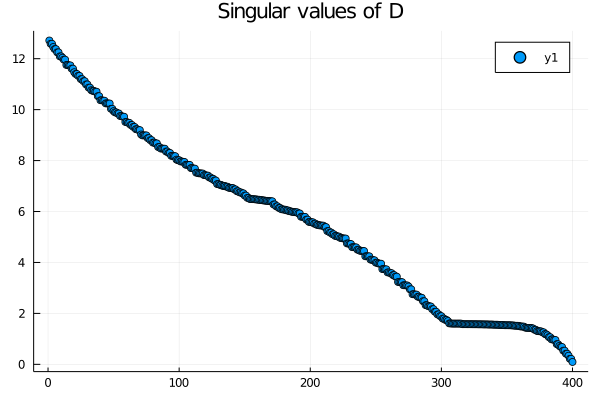

In [238]:
plot(F.S, seriestype = :scatter, title = "Singular values of D", 
#     yaxis=:log
)

In [239]:
# Inspect the smallest singular values
F.S[end-5:end]

6-element Array{Float64,1}:
 0.41844073024064754
 0.4172485446862489
 0.33911450940750965
 0.2164738342990691
 0.21460250369920525
 0.09299875824304688

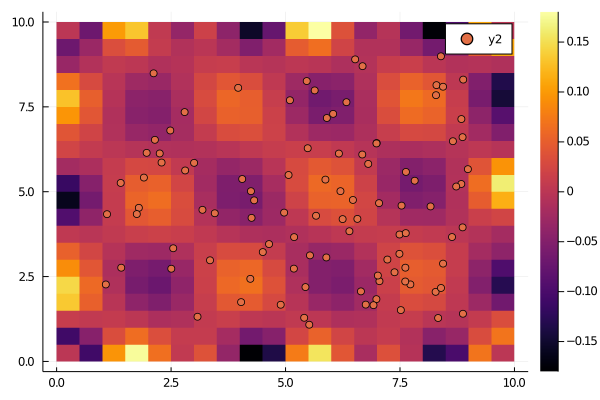

In [247]:
heatmap(
    xcticks, ycticks, 
    reshape(F.V[:,350], (nx,ny)),
)
scatter!(rx,ry)

## Compute various rank truncations

In [241]:
# Optimal rank using Gavish & Donoho 2013
m,n = size(D)
beta = m/n
omega = 0.56 * beta^3 - 0.95 * beta^2 + 1.82 * beta + 1.43
tau = omega * median(F.S)
r = sum(F.S .> tau)
println("Optimal rank (G&D,13): r=",r)

# Optimal rank using energy method
energy = 0.99
cum_energy = cumsum(F.S.^2) / sum(F.S.^2)
r_e = searchsortedfirst(cum_energy, energy)
println("Optimal rank (energy method): r=",r_e," for ",energy*100," % of the energy")

r=1
Ur = F.U[:,1:r];
Sr = F.S[1:r];
Vr = F.V[:,1:r];  # note: it would be more efficient to extract Vt.

Dr = Ur * Diagonal(Sr) * Vr';
size(Dr)

Optimal rank (G&D,13): r=43
Optimal rank (energy method): r=311 for 99.0 % of the energy


(500, 400)

## Construct slowness perturbation field

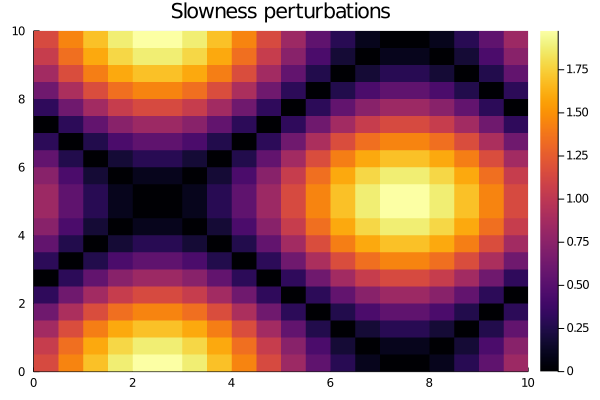

In [242]:
## Step 7: Impose some (say, sinusoidal) structure on the grid, i.e. the slowness perturbation array, S

# Compute array of perturbations separately

# plotting ref: http://docs.juliaplots.org/latest/generated/plotly/#plotly-ref22
wλ=grid.nx * grid.Δx / 1;
f(x, y) = begin
    abs(sin.(2π/wλ*x) + cos.(2π/wλ*y))
end

Z = Array{Float64}(undef, length(grid.nodes))
for (i, node) in enumerate(grid.nodes)
    Z[i] = f(node.x, node.y)
end

heatmap(xcticks, ycticks, f.(xcticks',ycticks))
title!("Slowness perturbations")

## Compute arrival times and invert using `pinv`

In [243]:
## Step 8: Compute arrival times by τ=D*S
τ = D * Z;

In [244]:
## Step 9: Invert τ using the pseudoinverse of D, where you only keep the first k singular values of svd(D).
Pi = pinv(M,atol=1e-5);  # https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.pinv
S_approx = Pi*[τ; zeros(nx*ny)];
# S_approx = Dr\τ;

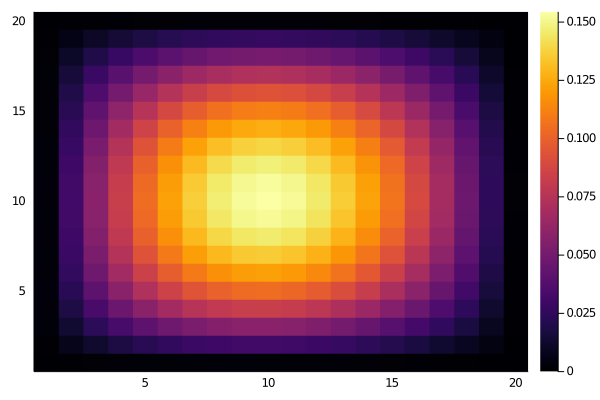

In [245]:
heatmap(reshape(S_approx,(nx,ny)))

## Use arrival times and invert by direct computation

We seek to compute the following inverse:

\begin{equation}
\tilde{x} =
    \left(
        D^T D + \lambda^2 L^T L
    \right)^{-1}
    D^T y
\end{equation}
where $D$ is the design matrix, describing the distance sampled in the grid boxes by each float. $L$ is a regularizing matrix, which is the Laplacian with homogeneous boundary conditions in this case. $\lambda$ is a smoothing parameter which modulates the impact of the smoothing on the solution.

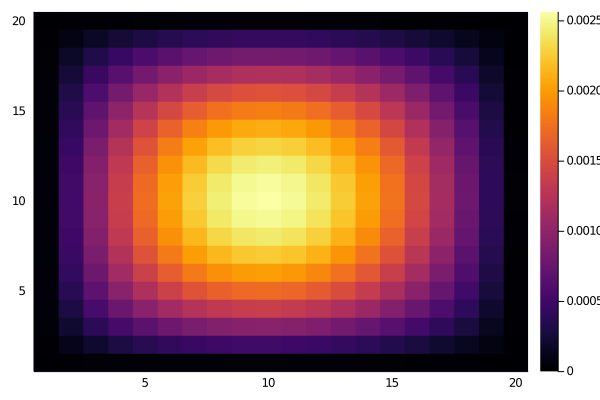

In [246]:
# Compute pseudoinverse of D'D+λ²L'L
λ=grid.nx * grid.Δx / 3;
mat = D' * D + λ^2 * L' * L;  # matrix to compute pseudoinverse of

P = svd(mat)
sz=nx*ny  # full rank
r=sz      # chosen rank
Ur = P.U[:,1:r]; Sr = P.S[1:r]; Vr = P.V[:,1:r];  # SVD decomposition
inver = Vr * diagm(1 ./ Sr) * Ur' # Moore-Penrose Inverse

# Compute approximate inverse
x̃ = inver * D' * τ;

heatmap(reshape(x̃,(nx,ny)))